## Part 0 - Data Preparation

----------------------------------------

In [1]:
import requests
def fetch_historical_data(coin_id):
    url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart?vs_currency=usd&days=30"
    response = requests.get(url)
    return response.json()

In [2]:
raw_data = fetch_historical_data('bitcoin')
headers = list(raw_data)
headers

['prices', 'market_caps', 'total_volumes']

In [3]:
prices = [i[1] for i in raw_data['prices']]
market_caps = [i[1] for i in raw_data['market_caps']]
total_volumes = [i[1] for i in raw_data['total_volumes']]
prices[0], market_caps[0], total_volumes[0]

(64501.15829950209, 1273504106880.1143, 24474984657.611523)

In [4]:
import datetime as dt

In [5]:
dates = [dt.datetime.fromtimestamp(i[0]/1000) for i in raw_data['prices']]
dates[0].strftime('%Y-%m-%d %H:%M:%S')

'2024-09-23 03:22:08'

In [6]:
import numpy as np

In [7]:
data = np.array([dates, prices, market_caps, total_volumes])
data[1][:3]

array([64501.15829950209, 64306.459582669086, 63792.9532888288],
      dtype=object)

In [8]:
def normalize(arr):
    mean = np.mean(arr)
    std = np.std(arr)
    return ((arr - mean) / std)/2

Values from -1 to +1

In [9]:
normalized_data = np.array([dates, normalize(prices), normalize(market_caps), normalize(total_volumes)])
normalized_data[1][:3]

array([0.041414301573380066, 0.0024646249001698786, -0.10026283237369016],
      dtype=object)

In [10]:
dates[:3]

[datetime.datetime(2024, 9, 23, 3, 22, 8, 672000),
 datetime.datetime(2024, 9, 23, 4, 1, 39, 283000),
 datetime.datetime(2024, 9, 23, 5, 25, 59, 881000)]

In [11]:
dates[-3:]

[datetime.datetime(2024, 10, 23, 1, 18, 22, 665000),
 datetime.datetime(2024, 10, 23, 2, 1, 11, 516000),
 datetime.datetime(2024, 10, 23, 2, 52, 1)]

This implies the data is for the last month at 1hr intervals

----------------------------------------

## Part 1 - Data Visualisation

----------------------------------------

In [12]:
import pandas as pd
import datetime as dt

In [13]:
data = {
    'Timestamp': [date.strftime('%m/%d %H:%M') for date in dates],
    'Price': [f'${price:,.0f}' for price in prices],  # Formatting price
    'Market Cap': [f'${cap/1e9:.0f}B' for cap in market_caps],  # Formatting market cap
    'Total Volume': [f'${volume/1e9:.0f}B' for volume in total_volumes]  # Formatting total volume
}

pd.set_option('display.float_format', '{:.0f}'.format)
pd.DataFrame(data)

,Timestamp,Price,Market Cap,Total Volume
0,09/23 03:22,"$64,501",$1274B,$24B
1,09/23 04:01,"$64,306",$1270B,$26B
2,09/23 05:25,"$63,793",$1260B,$28B
3,09/23 06:19,"$63,652",$1258B,$24B
4,09/23 07:07,"$63,625",$1257B,$27B
...,...,...,...,...
716,10/22 23:08,"$67,672",$1338B,$35B
717,10/23 00:15,"$67,315",$1333B,$35B
718,10/23 01:18,"$67,140",$1328B,$33B
719,10/23 02:01,"$67,291",$1330B,$27B


In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

In [15]:
start_date = dates[0]
end_date = dates[-1]

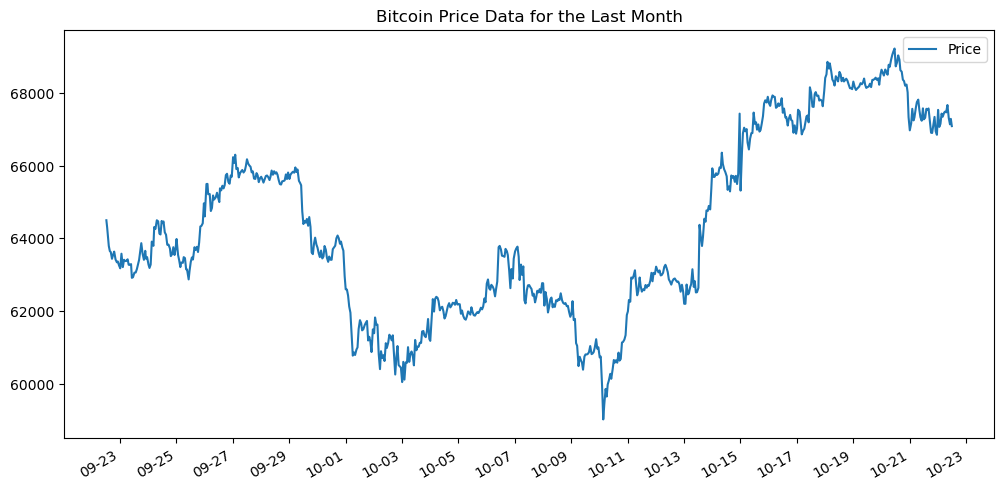

In [16]:
plt.figure(figsize=(12, 6))

plt.plot(dates, prices, label='Price')

plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=48))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.ticklabel_format(style='plain', axis='y')

plt.gcf().autofmt_xdate()

plt.title('Bitcoin Price Data for the Last Month')
plt.legend()

plt.show()

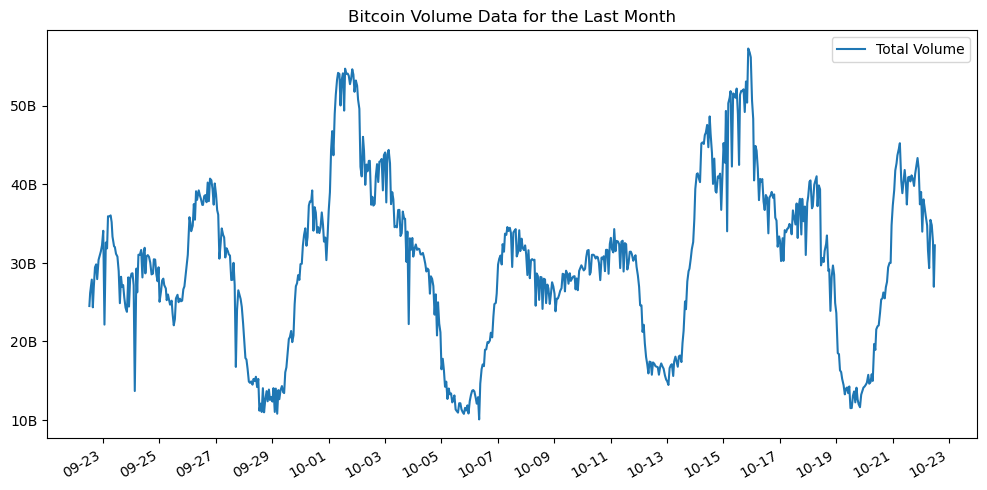

In [17]:
plt.figure(figsize=(12, 6))

plt.plot(dates, total_volumes, label='Total Volume')

plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=48))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

formatter = ticker.FuncFormatter(lambda x, _: f'{x/1e9:.0f}B')
plt.gca().yaxis.set_major_formatter(formatter)

plt.gcf().autofmt_xdate()

plt.title('Bitcoin Volume Data for the Last Month')
plt.legend()

plt.show()

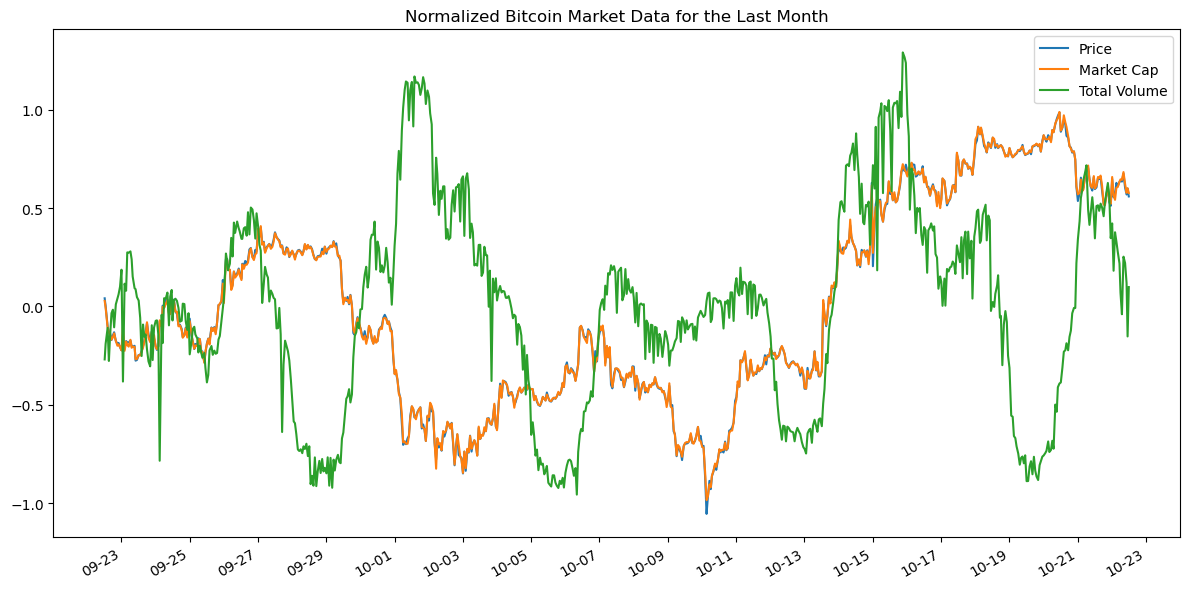

In [18]:
plt.figure(figsize=(12, 6))

plt.plot(normalized_data[0], normalized_data[1], label='Price')
plt.plot(normalized_data[0], normalized_data[2], label='Market Cap')
plt.plot(normalized_data[0], normalized_data[3], label='Total Volume')

plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=48))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.ticklabel_format(style='plain', axis='y')

plt.gcf().autofmt_xdate()

plt.title('Normalized Bitcoin Market Data for the Last Month')
plt.legend()
plt.tight_layout()

plt.show()

Price and Market Cap have a 1:1 correlation.

----------------------------------------

## Part 2: Data Analysis

----------------------------------------

In [19]:
import scipy.stats as stats

In [20]:
def z_score(arr, z):
    return (stats.norm.cdf(z) - stats.norm.cdf(-z))

In [21]:
price_std = {}
for i in range(1,5):
     price_std[i] = f"{z_score(prices, i)*100:.2f}%"
        
pd.DataFrame(list(price_std.items()), columns=['Standard Deviation', 'Percentage'])

,Standard Deviation,Percentage
0,1,68.27%
1,2,95.45%
2,3,99.73%
3,4,99.99%


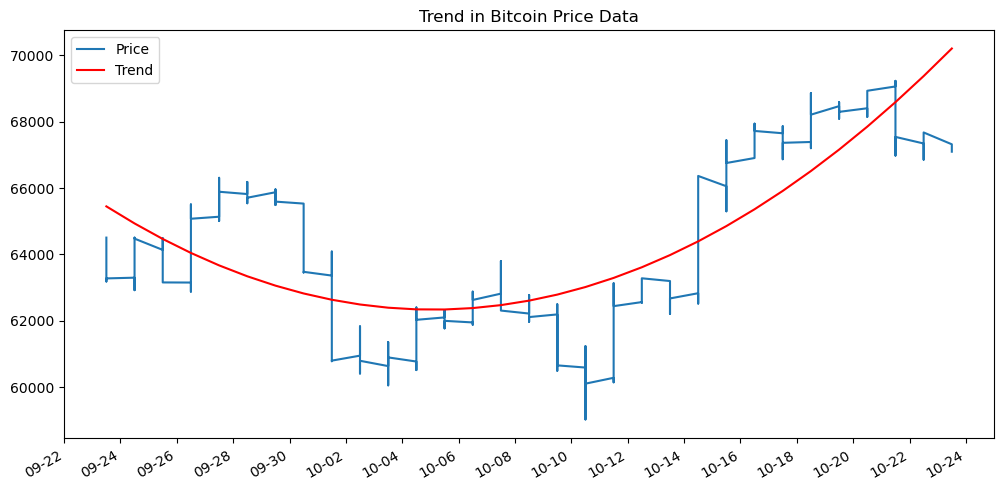

In [22]:
plt.figure(figsize=(12, 6))

x = [date.toordinal() for date in dates]
y = prices

plt.plot(x, y, label='Price')

coefficients = np.polyfit(x, y, 2)
trendline = np.poly1d(coefficients)

plt.plot(x, trendline(x), color='red', label='Trend')

plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=48))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gcf().autofmt_xdate()

plt.title('Trend in Bitcoin Price Data')
plt.legend()
plt.show()

The price exhibits an upward trend, resembling a parabolic curve, where there is a temporary dip within a predominantly positive long-term price movement.

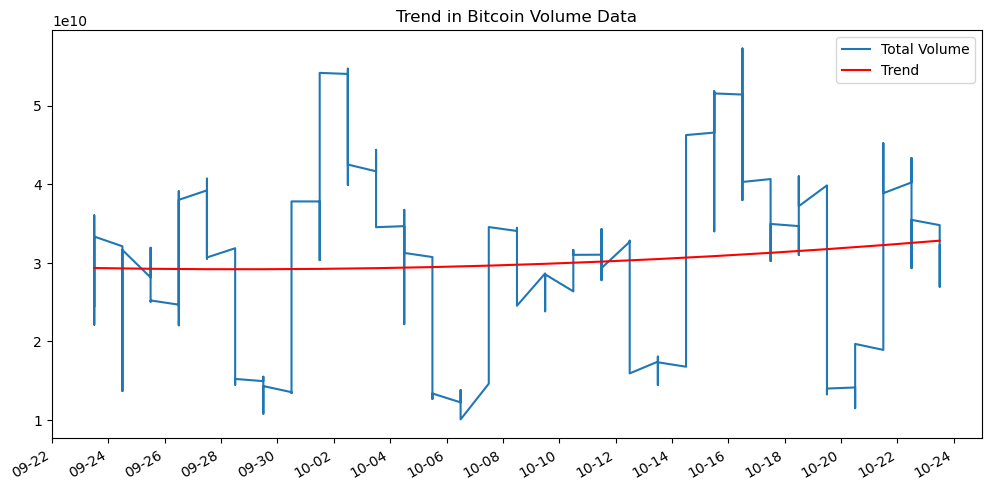

In [23]:
plt.figure(figsize=(12, 6))

x = [date.toordinal() for date in dates]
y = total_volumes

plt.plot(x, y, label='Total Volume')

coefficients = np.polyfit(x, y, 2)
trendline = np.poly1d(coefficients)

plt.plot(x, trendline(x), color='red', label='Trend')

plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=48))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gcf().autofmt_xdate()

plt.title('Trend in Bitcoin Volume Data')
plt.legend()
plt.show()

The total volume exhibits no noticable trend.

In [24]:
def outliers(dates_arr, values_arr, z):
    dates_arr = np.array(dates_arr)
    values_arr = np.array(values_arr)

    mean = np.mean(values_arr)
    std = np.std(values_arr)
    
    lb = mean - z * std
    ub = mean + z * std
    
    mask_outliers = (values_arr >= lb) & (values_arr <= ub)
    
    inliers = np.array([dates_arr[~mask_outliers].tolist(), values_arr[~mask_outliers].tolist()])
    outliers = np.array([dates_arr[mask_outliers].tolist(), values_arr[mask_outliers].tolist()])
    
    return inliers, outliers

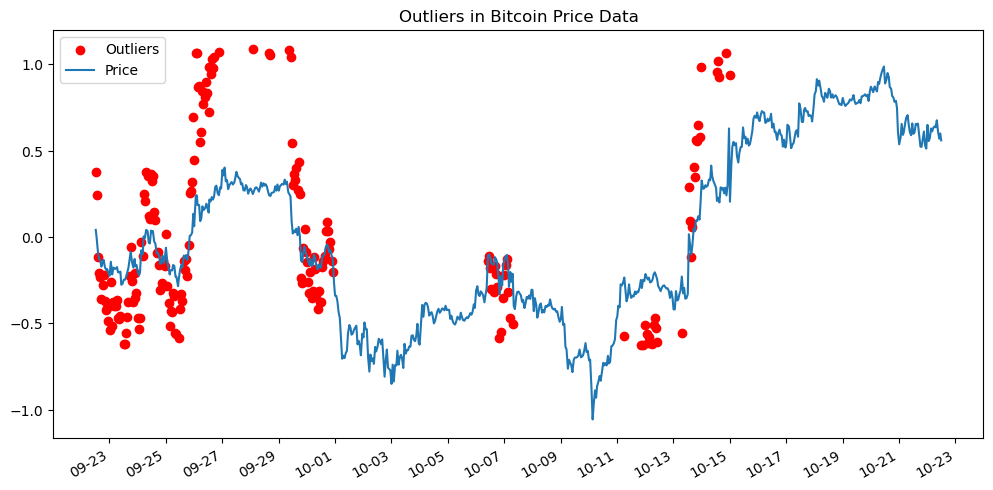

In [25]:
price_inliers, price_outliers = outliers(dates, prices, 0.5)

plt.figure(figsize=(12, 6))

plt.scatter(price_outliers[0], normalize(price_outliers[1]), label='Outliers', linestyle='-', color='red')
plt.plot(normalized_data[0], normalized_data[1], label='Price')

plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=48))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gcf().autofmt_xdate()

plt.title('Outliers in Bitcoin Price Data')
plt.legend()
plt.show()

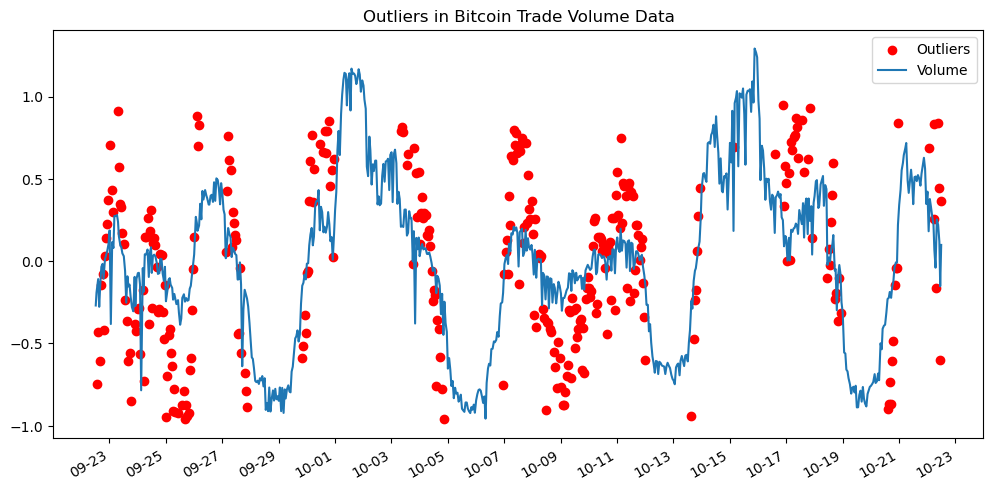

In [26]:
volume_inliers, volume_outliers = outliers(dates, total_volumes, 0.5)

plt.figure(figsize=(12, 6))

plt.scatter(volume_outliers[0], normalize(volume_outliers[1]), label='Outliers', linestyle='-', color='red')
plt.plot(normalized_data[0], normalized_data[3], label='Volume')

plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=48))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.gcf().autofmt_xdate()

plt.title('Outliers in Bitcoin Trade Volume Data')
plt.legend()
plt.show()

Outliers in trade volume are more widely than those in price.
This indicates that trade volume may be a more sensitive indicator of market dynamics compared to price.

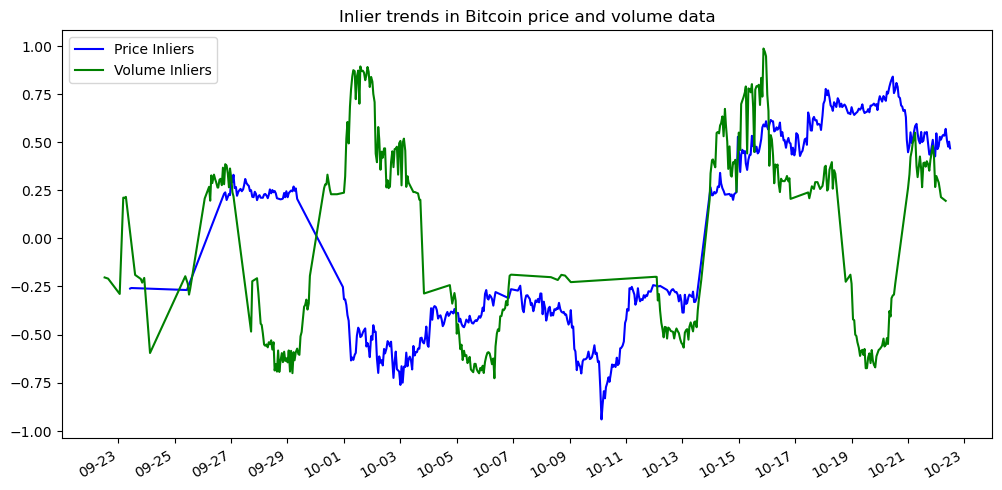

In [27]:
plt.figure(figsize=(12, 6))

plt.plot(price_inliers[0], normalize(price_inliers[1]), label='Price Inliers', linestyle='-', color='blue')
plt.plot(volume_inliers[0], normalize(volume_inliers[1]), label='Volume Inliers', linestyle='-', color='green')

plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=48))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.gcf().autofmt_xdate()

plt.title('Inlier trends in Bitcoin price and volume data')
plt.legend()
plt.show()

Price and volume exhibit a relatively inverse trend during significant changes, indicating that when volume spikes or drops, price does not respond similarly. 

----------------------------------------

## Part 2.1: Further Analysis

To be continued...

----------------------------------------